In [1]:
from pathlib import Path
import sys  
import os
import pandas as pd 
from datetime import datetime
import scipy.sparse as sps
from numpy import linalg as LA
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt

import numpy as np
from operator import itemgetter

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "libs")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

%load_ext autoreload
%autoreload 2

In [3]:
from Utils.load_URM import load_URM
from Utils.load_ICM import load_ICM

from scipy.sparse import hstack, vstack
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_all = load_URM("../data/data_train.csv")
ICM_all = load_ICM("../data/data_ICM_metadata.csv")

In [4]:
ICM_df = pd.read_csv("../data/data_ICM_metadata.csv")
ICM_df = ICM_df.rename(columns = {"item_id": "ItemID"})

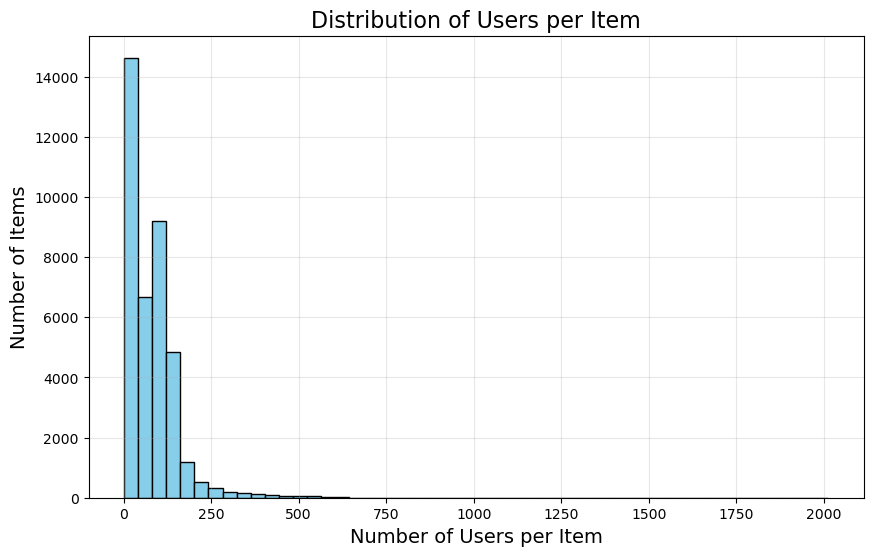

Top 10 items with the most users:
ItemID
15084    2013
22337    1199
8646     1084
4135     1019
6730      996
4953      986
23345     805
6694      791
13224     779
15318     775
16031     763
13322     755
15638     729
7535      729
12775     720
22377     705
23510     703
4634      691
4514      691
4150      680
dtype: int64


In [5]:
item_distribution = ICM_df.groupby("ItemID").size()

# Sort the distribution for better visualization (optional)
item_distribution_sorted = item_distribution.sort_values(ascending=False)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(item_distribution, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Users per Item", fontsize=16)
plt.xlabel("Number of Users per Item", fontsize=14)
plt.ylabel("Number of Items", fontsize=14)
plt.grid(alpha=0.3)
plt.show()

# Optionally, inspect items with the most users
top_items = item_distribution_sorted.head(20)
print("Top 10 items with the most users:")
print(top_items)

In [6]:
SELECTED_FEATURES = item_distribution_sorted.head(10).keys().values

In [7]:
SELECTED_FEATURES

array([15084, 22337,  8646,  4135,  6730,  4953, 23345,  6694, 13224,
       15318])

In [8]:
from libs.Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender 
from libs.Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from libs.Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from libs.Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from libs.Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

In [9]:
import optuna as op
from xgboost import XGBRanker
from xgboost import plot_importance

In [10]:
def create_dataframe_with_label(URM_features, URM_label, other_algorithms, cutoff, selected_features=
                                SELECTED_FEATURES):
    n_users_features, n_items_features = URM_features.shape
    training_dataframe = pd.DataFrame(index=range(0,n_users_features), columns = ["ItemID"])
    training_dataframe.index.name='UserID'
    #print(training_dataframe.columns)

    for user_id in range(n_users_features):    
        recommendations = other_algorithms["candidate_generator"].recommend(user_id, cutoff = cutoff)
        training_dataframe.loc[user_id, "ItemID"] = recommendations
        
    #print(training_dataframe.columns)
    training_dataframe = training_dataframe.explode("ItemID")

    URM_label_coo = sps.coo_matrix(URM_label)

    correct_recommendations = pd.DataFrame({"UserID": URM_label_coo.row,
                                        "ItemID": URM_label_coo.col})

    training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
    training_dataframe["Label"] = training_dataframe["Exist"] == "both"
    training_dataframe.drop(columns = ['Exist'], inplace=True)
    
    training_dataframe = training_dataframe.set_index('UserID')

    for user_id in range(n_users_features):  
        for rec_label, rec_instance in other_algorithms.items():
            if rec_label!= "candidate_generator":
                item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
                all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

                training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

    training_dataframe = training_dataframe.reset_index()
    training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
    
    item_popularity = np.ediff1d(sps.csc_matrix(URM_features).indptr)

    training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
    
    user_popularity = np.ediff1d(sps.csr_matrix(URM_features).indptr)

    training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
    
    training_dataframe = training_dataframe.sort_values("UserID").reset_index()
    training_dataframe.drop(columns = ['index'], inplace=True)

     # Filter feature_data by selected_features
    filtered_features = ICM_df[ICM_df['feature_id'].isin(selected_features)]

    # Pivot the feature_data to create a sparse matrix-like structure
    feature_matrix = filtered_features.pivot(index='ItemID', columns='feature_id', values='data').fillna(0)

    # Merge feature data into training_dataframe
    training_dataframe = training_dataframe.merge(
        feature_matrix, on="ItemID", how="left"
    )
    training_dataframe = training_dataframe.fillna(0).infer_objects()
    
    return training_dataframe

In [11]:
def create_dataframe_without_label(URM_features, other_algorithms, cutoff, selected_features=
                                  SELECTED_FEATURES):
    n_users_features, n_items_features = URM_features.shape
    training_dataframe = pd.DataFrame(index=range(0,n_users_features), columns = ["ItemID"])
    training_dataframe.index.name='UserID'
    #print(training_dataframe.columns)
    #print(training_dataframe)
    
    for user_id in range(n_users_features):    
        recommendations = other_algorithms["candidate_generator"].recommend(user_id, cutoff = cutoff)
        training_dataframe.loc[user_id, "ItemID"] = recommendations
        
    #print(training_dataframe.columns)
    #print(training_dataframe)
    training_dataframe = training_dataframe.explode("ItemID")
    #training_dataframe = training_dataframe.set_index('UserID')

    for user_id in range(n_users_features):  
        for rec_label, rec_instance in other_algorithms.items():
            if rec_label!= "candidate_generator":
                item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
                all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

                training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

    training_dataframe = training_dataframe.reset_index()
    training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
    
    item_popularity = np.ediff1d(sps.csc_matrix(URM_features).indptr)

    training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
    ,
    user_popularity = np.ediff1d(sps.csr_matrix(URM_features).indptr)

    training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
    
    training_dataframe = training_dataframe.sort_values("UserID").reset_index()
    training_dataframe.drop(columns = ['index'], inplace=True)

    filtered_features = ICM_df[ICM_df['feature_id'].isin(selected_features)]

    # Pivot the feature_data to create a sparse matrix-like structure
    feature_matrix = filtered_features.pivot(index='ItemID', columns='feature_id', values='data').fillna(0)

    # Merge feature data into training_dataframe
    training_dataframe = training_dataframe.merge(
        feature_matrix, on="ItemID", how="left"
    )
    training_dataframe = training_dataframe.fillna(0).infer_objects()
    
    return training_dataframe

In [12]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

In [13]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=10):
    
    #cumulative_precision = 0.0
    #cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, cutoff=at)
            num_eval+=1

            #cumulative_precision += precision(recommended_items, relevant_items)
            #cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    #cumulative_precision /= num_eval
    #cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    return MAP

def evaluate_algorithm_xgboost(URM_test, dataframe_to_evaluate, model):
    
    cumulative_AP = 0.0
    
    num_eval = 0

    # we look for all the users 
    for user_id in tqdm(range(URM_test.shape[0])):
        
        # we get the relevant items for this user
        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        # if the user have something in the test data we evaluate it
        if len(relevant_items)>0:
            
            X_to_predict = dataframe_to_evaluate[dataframe_to_evaluate["UserID"] == user_id].copy()

            preds = model.predict(X_to_predict)
            X_to_predict["rank"] = preds
            X_to_predict = X_to_predict.sort_values(by = "rank", ascending = False)
            recommended_items = np.array(X_to_predict["ItemID"])[:10]
            
            num_eval+=1

            cumulative_AP += AP(recommended_items, relevant_items)
            
    MAP = cumulative_AP / num_eval
    
    return MAP

In [14]:
URM_train = sps.load_npz("URM_train_ens.npz")
URM_val = sps.load_npz("URM_val_ens.npz")
URM_test = sps.load_npz("URM_test_ens.npz")

URM_train_val = sps.load_npz("URM_train_val_ens.npz")

In [15]:
SLIM_ElasticRecall_train_val = SLIMElasticNetRecommender(URM_train_val)
SLIM_ElasticRecall_train_val.load_model("result_experiments/SLIM/", "SLIM_ElasticRecall_train_val")
#SLIM_ElasticRecall_train_val.fit(topK= 296, l1_ratio=0.10442943478590742, alpha=0.00035921608889258387)
#SLIM_ElasticRecall_train_val_eval.load_model('result_experiments/SLIM/', 'slim_307_train_val_ens')

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_ElasticRecall_train_val'
SLIMElasticNetRecommender: Loading complete


In [16]:
# SLIM_ElasticRecall_train_val.save_model("result_experiments/SLIM/", "SLIM_ElasticRecall_train_val")

In [17]:
RP3BetaRecall_train_val = RP3betaRecommender(URM_train_val)
RP3BetaRecall_train_val.load_model("result_experiments/RP3beta/", "RP3BetaRecall_train_val")
#RP3BetaRecall_train_val.fit(alpha=0.205870, beta=0.243986, topK=17, min_rating=0.0, implicit=False, normalize_similarity=True)

RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3BetaRecall_train_val'
RP3betaRecommender: Loading complete


In [18]:
# RP3BetaRecall_train_val.save_model("result_experiments/RP3beta/", "RP3BetaRecall_train_val")

In [19]:
KNNRecall_train_val = ItemKNNCFRecommender(URM_train_val)
KNNRecall_train_val.load_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_train_val")
# KNNRecall_train_val.fit(similarity='tversky', topK=5, shrink=24.383723,
#                    feature_weighting='none', tversky_alpha=0.405750,
#                    tversky_beta=1.823707,
#                    normalize=True)

ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNNRecall_train_val'
ItemKNNCFRecommender: Loading complete


In [20]:
#KNNRecall_train_val.save_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_train_val")

In [21]:
new_similarityRecall_train_val = 0.7747783599151299 * SLIM_ElasticRecall_train_val.W_sparse + 0.10970438576060675 * RP3BetaRecall_train_val.W_sparse + 0.1155172543242634 * KNNRecall_train_val.W_sparse
candidate_gen_train_val = ItemKNNCustomSimilarityRecommender(URM_train_val)
candidate_gen_train_val.fit(new_similarityRecall_train_val)

In [22]:
SLIM_Elastic_train_val = SLIMElasticNetRecommender(URM_train_val)
SLIM_Elastic_train_val.load_model("result_experiments/SLIM/", "SLIM_Elastic_train_val_eval")

RP3Beta_train_val = RP3betaRecommender(URM_train_val)
RP3Beta_train_val.load_model("result_experiments/RP3beta/", "RP3Beta_train_val_eval")

KNN_train_val = ItemKNNCFRecommender(URM_train_val)
KNN_train_val.load_model("result_experiments/ItemKNNCFRecommender/", "KNN_train_val_eval")

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_Elastic_train_val_eval'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3Beta_train_val_eval'
RP3betaRecommender: Loading complete
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNN_train_val_eval'
ItemKNNCFRecommender: Loading complete


In [23]:
# SLIM_Elastic_train_val.save_model("result_experiments/SLIM/", "SLIM_Elastic_train_val")

# RP3Beta_train_val.save_model("result_experiments/RP3beta/", "RP3Beta_train_val")

# KNN_train_val.save_model("result_experiments/ItemKNNCFRecommender/", "KNN_train_val")


In [24]:
best_similarity_train_val = 0.862708291473966 * SLIM_Elastic_train_val.W_sparse + 0.10238146945917358 * RP3Beta_train_val.W_sparse + 0.034910239066860506 * KNN_train_val.W_sparse
best_hybrid_train_val = ItemKNNCustomSimilarityRecommender(URM_train_val)
best_hybrid_train_val.fit(best_similarity_train_val)

In [25]:
other_algorithms_train_val = {
    "RP3beta": RP3BetaRecall_train_val,
    "SLIM": SLIM_ElasticRecall_train_val,
    "KNN": KNNRecall_train_val,
    "best_hybrid": best_hybrid_train_val,
    # "SLIM_bpr":SLIM_bpr,
    # "P3a":P3a,
    "candidate_generator": candidate_gen_train_val
}

In [26]:
cutoff = 32
n_estimators = 737
learning_rate = 0.468191
reg_alpha = 45.856709
reg_lambda = 0.368126
max_depth = 5
max_leaves = 6
min_child_weight = 5
colsample_bytree = 0.713307
subsample = 0.651620
gamma = 4.341156
max_bin = 322

# cutoff = 36
# n_estimators = 614
# learning_rate = 0.30994023511230956
# reg_alpha = 44.058468857939474
# reg_lambda = 0.5164668842790255
# max_depth = 11
# max_leaves = 9
# min_child_weight = 6
# colsample_bytree = 0.6382204257563306
# subsample = 0.8705350402895549
# gamma = 5.578344850591417
# max_bin = 542

# cutoff = 29
# n_estimators = 712
# learning_rate = 0.47176372924803495
# reg_alpha = 37.408430876720004
# reg_lambda = 0.459031876315078
# max_depth = 6
# max_leaves = 13
# min_child_weight = 10
# colsample_bytree = 0.797564263530743
# subsample = 0.8427864021709097
# gamma = 5.268682714351331
# max_bin = 570

# cutoff = 33
# n_estimators = 734
# learning_rate = 0.3220652624797847
# reg_alpha = 33.0894798497184
# reg_lambda = 0.5041606291417153
# max_depth = 4
# max_leaves = 7
# min_child_weight = 5
# colsample_bytree = 0.6215918361638323
# subsample = 0.9970033845065275
# gamma = 4.2690557138141605
# max_bin= 430

# cutoff = 66
# n_estimators = 849
# learning_rate = 0.3637770992742871
# reg_alpha = 50.44532162296401
# reg_lambda = 0.3859479066775696
# max_depth = 8
# max_leaves = 5

# n_estimators = 606
# learning_rate = 0.2158940080664111
# reg_alpha = 33.243341201150095
# reg_lambda = 0.595330196145776
# max_depth = 5
# max_leaves = 5

# n_estimators = 337
# learning_rate = 0.010444729746988764
# reg_alpha = 46.678022346382555
# reg_lambda = 0.30629160267515565
# max_depth = 4
# max_leaves = 6

grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
random_seed = None



training_dataframe = create_dataframe_with_label(URM_train_val, URM_test, other_algorithms_train_val, cutoff)
groups = training_dataframe.groupby("UserID").size().values

y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")


XGB_model = XGBRanker(objective='rank:{}'.format(objective),
      n_estimators = int(n_estimators),
      random_state = random_seed,
      learning_rate = learning_rate,
      reg_alpha = reg_alpha,
      reg_lambda = reg_lambda,
      max_depth = int(max_depth),
      max_leaves = int(max_leaves),
      grow_policy = grow_policy,
      verbosity = 0, # 2 if self.verbose else 0,
      booster = booster,
      enable_categorical = True,
      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
      
      min_child_weight=min_child_weight,
      colsample_bytree=colsample_bytree,
      subsample=subsample,
      gamma=gamma,
      max_bin=max_bin
    )

XGB_model.fit(X_train,
    y_train,
    group=groups,
    verbose=True)

/var/folders/tr/d1rx7zt15lzgkp2yc1nwbg100000gn/T/ipykernel_69305/726086598.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training_dataframe = training_dataframe.fillna(0).infer_objects()


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.713307, device=None, early_stopping_rounds=None,
          enable_categorical=True, eval_metric=None, feature_types=None,
          gamma=4.341156, grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.468191, max_bin=322,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=6, min_child_weight=5, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=737,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [27]:
XGB_model.feature_importances_

array([0.        , 0.        , 0.25723556, 0.23826104, 0.06289635,
       0.269362  , 0.0524453 , 0.11979973, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

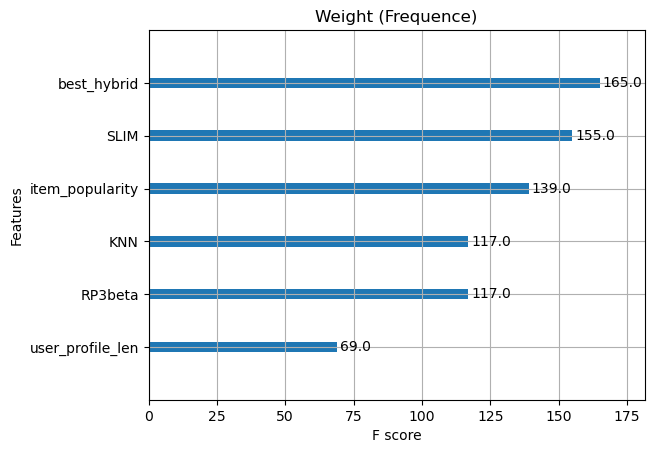

In [28]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [29]:
SLIM_ElasticRecall_all = SLIMElasticNetRecommender(URM_all)
SLIM_ElasticRecall_all.load_model("result_experiments/SLIM/", "SLIM_ElasticRecall_all")
#SLIM_ElasticRecall_all.fit(topK= 296, l1_ratio=0.10442943478590742, alpha=0.00035921608889258387)

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_ElasticRecall_all'
SLIMElasticNetRecommender: Loading complete


In [30]:
# SLIM_ElasticRecall_all.save_model("result_experiments/SLIM/", "SLIM_ElasticRecall_all")

In [31]:
RP3BetaRecall_all = RP3betaRecommender(URM_all)
RP3BetaRecall_all.load_model("result_experiments/RP3beta/", "RP3BetaRecall_all")
# RP3BetaRecall_all.fit(alpha=0.205870, beta=0.243986, topK=17,
#                        min_rating=0.0, implicit=False, normalize_similarity=True)

RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3BetaRecall_all'
RP3betaRecommender: Loading complete


In [32]:
# RP3BetaRecall_all.save_model("result_experiments/RP3beta/", "RP3BetaRecall_all")

In [33]:
KNNRecall_all = ItemKNNCFRecommender(URM_all)
KNNRecall_all.load_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_all")
# KNNRecall_all.fit(similarity='tversky', topK=5, shrink=24.383723,
#                    feature_weighting='none', tversky_alpha=0.405750,
#                    tversky_beta=1.823707,
#                    normalize=True)

ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNNRecall_all'
ItemKNNCFRecommender: Loading complete


In [34]:
# KNNRecall_all.save_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_all")

In [35]:
new_similarityRecall_all = 0.7747783599151299 * SLIM_ElasticRecall_all.W_sparse + 0.10970438576060675 * RP3BetaRecall_all.W_sparse + 0.1155172543242634 * KNNRecall_all.W_sparse
candidate_gen_all = ItemKNNCustomSimilarityRecommender(URM_all)
candidate_gen_all.fit(new_similarityRecall_all)

In [36]:
SLIM_Elastic_all = SLIMElasticNetRecommender(URM_all)
SLIM_Elastic_all.load_model("result_experiments/SLIM/", "SLIM_Elastic_all")
#SLIM_Elastic_all.fit(topK =320, l1_ratio=0.1527515113685262, alpha=0.00022576119312621578)

RP3Beta_all = RP3betaRecommender(URM_all)
RP3Beta_all.load_model("result_experiments/RP3beta/", "RP3Beta_all")
# RP3Beta_all.fit(alpha=0.4176290154380183, beta=0.21520987912346945,
#                 topK=19, min_rating=0.0, implicit=False, normalize_similarity=True)

KNN_all = ItemKNNCFRecommender(URM_all) 
KNN_all.load_model("result_experiments/ItemKNNCFRecommender/", "KNN_all")
# KNN_all.fit(
#     similarity='tversky', 
#     topK = 6,
#     shrink= 21.589349496863413,
#     feature_weighting= 'TF-IDF',
#     normalize= False,
#     tversky_alpha= 0.16725184866550824,
#     tversky_beta= 1.722012798691049
# )


SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_Elastic_all'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3Beta_all'
RP3betaRecommender: Loading complete
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNN_all'
ItemKNNCFRecommender: Loading complete


In [37]:
best_similarity_all = 0.862708291473966 * SLIM_Elastic_all.W_sparse + 0.10238146945917358 * RP3Beta_all.W_sparse + 0.034910239066860506 * KNN_all.W_sparse
best_hybrid_all = ItemKNNCustomSimilarityRecommender(URM_all)
best_hybrid_all.fit(best_similarity_all)

In [38]:
other_algorithms_all = {
    "RP3beta": RP3BetaRecall_all,
    "SLIM": SLIM_ElasticRecall_all,
    "KNN": KNNRecall_all,
    "best_hybrid": best_hybrid_all,
    # "SLIM_bpr":SLIM_bpr,
    # "P3a":P3a,
    "candidate_generator": candidate_gen_all
}

In [40]:
final_dataframe = create_dataframe_without_label(URM_all, other_algorithms_all, cutoff)

/var/folders/tr/d1rx7zt15lzgkp2yc1nwbg100000gn/T/ipykernel_69305/716255068.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training_dataframe = training_dataframe.fillna(0).infer_objects()


In [41]:
final_dataframe["UserID"] = final_dataframe["UserID"].astype("category")
final_dataframe["ItemID"] = final_dataframe["ItemID"].astype("category")

In [42]:
def generate_submission_xgb(model, dataframe, filename: str = "submission_xgb.csv"):

    target_users_test = pd.read_csv("../data/data_target_users_test.csv",).to_numpy().ravel()

    recommendations = []

    for user_id in tqdm(target_users_test):
        X_to_predict = dataframe[dataframe["UserID"] == user_id].copy()
        preds = model.predict(X_to_predict)

        X_to_predict["rank"] = preds
        X_to_predict = X_to_predict.sort_values(by = "rank", ascending = False)
        recommended_items = np.array(X_to_predict["ItemID"])[:10]
        recommendations.append(recommended_items)
    
    with open(f"../submissions/{filename}", "w") as f:
        f.write("user_id,item_list\n")
        for user_id, recs in zip(target_users_test, recommendations):
            f.write(f"{user_id},{' '.join(map(str, recs))}\n")

In [43]:
output_file = generate_submission_xgb(XGB_model, final_dataframe, "xgb_8.csv")

100%|████████████████████████████████████| 34231/34231 [01:05<00:00, 522.23it/s]


In [43]:
pred6 = pd.read_csv("../submissions/xgb_6.csv")
pred7 = pd.read_csv("../submissions/xgb_7.csv")

In [46]:
(pred7 == pred6).sum()

user_id      34231
item_list    33806
dtype: int64

In [47]:
pred7 == pred6

,user_id,item_list
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
34226,True,True
34227,True,True
34228,True,True
34229,True,True


In [64]:
xgb_sub = xgb_sub.rename(columns={' item_list': 'item_list'})

In [53]:
slim_sub = pd.read_csv("../submissions/slim_urm_307.csv")

In [55]:
slim_sub['item_list']

0         572 7547 14888 7703 6348 9911 3074 8505 399 4232
1        6348 14748 13766 13733 3130 572 9812 8685 6546...
2        29964 22714 15542 22589 13252 21367 29656 8403...
3        25140 25079 25643 6827 9742 11362 6189 3671 11...
4        9812 15902 17624 8612 18647 9447 3454 15729 34...
                               ...                        
34226    36844 26093 36527 35548 27531 37461 36566 2679...
34227    28247 37719 27350 37874 33330 37211 38027 3773...
34228    37739 36263 38027 37427 35394 38049 36525 3617...
34229    37069 36610 36168 37067 37550 35345 35093 3688...
34230    37657 36493 36773 37445 36917 36034 37865 3692...
Name: item_list, Length: 34231, dtype: object

In [58]:
slim_sub.columns 

Index(['user_id', 'item_list'], dtype='object')

In [69]:
xgb_sub.columns 

Index(['user_id', 'item_list'], dtype='object')